# Load the data

In [1]:
import pandas as pd
import torch
from pytorch_lightning import Trainer
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import AlexNet_Weights
from torch import nn
from torchvision.models import ResNet50_Weights, ResNet18_Weights
from torchvision import models

from src.colors import bcolors
from config import Config
from src.training.data import EuroSatDataModule

c = bcolors()
config = Config()

In [2]:
from src.pickle_loader import load_object

stats = load_object("data/eurosat_ms_mean_std")
mean = stats['mean']
std = stats['std']
chan_idx = stats['idx']

In [3]:
from src.datasets.EuroSatMS import EuroSatMS
import kornia.augmentation as K

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv(config.TRAIN_FILE)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=61)

chan = [3, 2, 1]
num_classes = 10

transform_cnn = transforms.Compose([
    K.Normalize(mean=mean[chan], std=std[chan])
])

transform_pt = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=0.75),
    K.RandomVerticalFlip(p=0.75),
    K.RandomAffine(degrees=40, translate=None, shear=(0.2, 0.2), scale=(1, 1.2), padding_mode=1, p=0.75),
    K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
    K.CenterCrop(size=(64, 64))
)

ds_train = EuroSatMS(train_df, config.TRAIN_MS_DIR, select_chan=chan, augment=augmentation) #, transform=transform_cnn)
ds_val = EuroSatMS(val_df, config.TRAIN_MS_DIR, select_chan=chan, augment=augmentation) #, transform=transform_cnn)


Preloading images...
Number of images: 21600
Number of jobs:   -4 

Preloading images...
Number of images: 5400
Number of jobs:   -4 


In [4]:
BATCH_SIZE = 256

print(f"""{c.OKGREEN}Initializing the data module...{c.ENDC}""")
data_module = EuroSatDataModule(ds_train, ds_val, config.TRAIN_MS_DIR, BATCH_SIZE)

Initializing the data module...


In [5]:
def print_layers_require_grad(model_p, prefix=''):
    for name, module in model_p.named_children():
        full_name = f"{prefix + '.' if prefix else ''}{name}"
        if list(module.parameters(recurse=False)):
            print('\n' + full_name + '\n')
            for param_name, param in module.named_parameters(recurse=False):
                param_full_name = f"{full_name}.{param_name}"
                print(f"{param_full_name}: requires_grad={param.requires_grad}")
        print_layers_require_grad(module, prefix=full_name)

# CNN Model Training

In [6]:
from src.training.cnn import LitEuroSatCnn

lightning_model = LitEuroSatCnn(
    num_classes=10,
    learning_rate=0.025, 
    num_channels=len(chan), 
    kernel_size=[7, 3],
    momentum=0.9,
    gamma=0.9
)

trainer = Trainer(
    max_epochs=20,
    accelerator="gpu", 
    devices=1
)

trainer.fit(lightning_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EuroSatCNN       | 17.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.326    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [7]:
trainer.validate(lightning_model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7914814949035645     │
│         val_loss          │    0.5753946304321289     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5753946304321289, 'val_accuracy': 0.7914814949035645}]

# Pretrained Model Training
### Training Phase 1
##### Pretrained ResNet50, ResNet18, AlexNet Model

In [ ]:
# model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT)

In [ ]:
from pytorch_lightning.callbacks import BackboneFinetuning
from src.training.pretrainedModels import EuroSatPreTrainedModel

lightning_model = EuroSatPreTrainedModel(
    backbone=model, 
    learning_rate=0.003,
    momentum=0.8,
    gamma=0.9,
    n_classes=10
)

backbone_finetuning = BackboneFinetuning(
    unfreeze_backbone_at_epoch=2,
    lambda_func=lambda epoch: 1.1,
    backbone_initial_lr=0.00001,
    verbose=True
)

trainer = Trainer(
    max_epochs=10,
    callbacks=[backbone_finetuning],
    accelerator="gpu", 
    devices=1
)

# for param in lightning_model.model.classifier[6].parameters():
#     param.requires_grad = True

trainer.fit(lightning_model, datamodule=data_module)

In [ ]:
trainer.validate(lightning_model, datamodule=data_module)

In [ ]:
import gc

lightning_model = None
trainer = None
gc.collect()
torch.cuda.empty_cache()

### Training Phase 2

In [ ]:
# Adjust the learning rate and max epochs
NEW_LR = 1e-4
MOMENTUM = 0.9
NEW_EP = 5
CKP_PATH = "lightning_logs/version_0/checkpoints/epoch=9-step=740.ckpt"

lightning_model = EuroSatPreTrainedModel.load_from_checkpoint(
    CKP_PATH,
    model=model,
    learning_rate=NEW_LR,
    momentum=MOMENTUM
)

lightning_model.freeze_model()

for i in range(0, 7):
    for param in lightning_model.model.classifier[i].parameters():
        param.requires_grad = True
        
print_layers_require_grad(lightning_model.model) 
print(f"\n{c.OKGREEN}Starting training...{c.ENDC}\n")
trainer = Trainer(max_epochs=NEW_EP, accelerator="gpu", devices=1)
trainer.fit(lightning_model, datamodule=data_module)

In [ ]:
import gc

lightning_model = None
trainer = None
gc.collect()
torch.cuda.empty_cache()

# Predict on the test set

In [17]:
from torch import nn
from src.datasets.EuroSatTest import EuroSatTestSet
from torch.utils.data import DataLoader
from config import Config
import kornia.augmentation as K
from src.pickle_loader import load_object
from torchvision import transforms

config = Config()

stats = load_object("data/eurosat_ms_mean_std")
mean = stats['mean']
std = stats['std']
chan_idx = stats['idx']

stat_chan = [3, 2, 1]

transform_cnn = transforms.Compose([
    K.Normalize(mean=mean[chan], std=std[chan])
])

augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=0.75),
    K.RandomVerticalFlip(p=0.75),
    K.RandomAffine(degrees=40, translate=None, shear=(0.2, 0.2), scale=(1, 1.2), padding_mode=1, p=0.75),
    # K.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0),
    K.CenterCrop(size=(64, 64))
)

chan = [3, 2, 1]

dataset = EuroSatTestSet(config.TEST_MS_DIR, select_chan=chan, augment=augmentation) #, augment=augmentation)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)



Preloading images...
Number of images: 4232
Number of jobs:   -4 


In [18]:
from src.training.pretrainedModels import EuroSatPreTrainedModel
from src.training.cnn import LitEuroSatCnn
from config import Config

config = Config()

# model = EuroSatResNet.load_from_checkpoint("lightning_logs/version_1/checkpoints/epoch=4-step=425.ckpt")

model = LitEuroSatCnn.load_from_checkpoint(
    "lightning_logs/version_0/checkpoints/epoch=19-step=1700.ckpt",
    num_classes=10,
    num_channels=len(chan),
    kernel_size=[7, 3],
)

# Set the model to evaluation mode
model.eval()
model.freeze()

In [19]:
# Test the model
# model = lightning_model
# trainer.validate(model, datamodule=data_module)

In [20]:
import torch
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

N_CLASSES = 10
categorys = dataset.enc.categories_[0]

predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

with torch.no_grad():
    for batch in dataloader:
        inputs, samp_id = batch
        inputs = inputs.to(device)

        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1).cpu()
        
        _, preds = torch.max(probs, 1)
        preds = preds.cpu().numpy()
        
        preds_enc = np.zeros((preds.size, N_CLASSES))
        preds_enc[np.arange(preds.size), preds] = 1
        
        pred_labels = np.array([categorys[p] for p in preds])
        
        
        # print(preds[0])
        # print(preds_enc[0])
        # print(pred_labels[0])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu())
        probabilities.extend(probs.cpu())
        ohe.extend(preds_enc)


In [21]:
import pandas as pd


sub_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())

sub_df.to_csv('submission.csv', index=False)

      test_id          label
1218        0        Pasture
1454        1  PermanentCrop
29          2     AnnualCrop
2598        3    Residential
2512        4  PermanentCrop


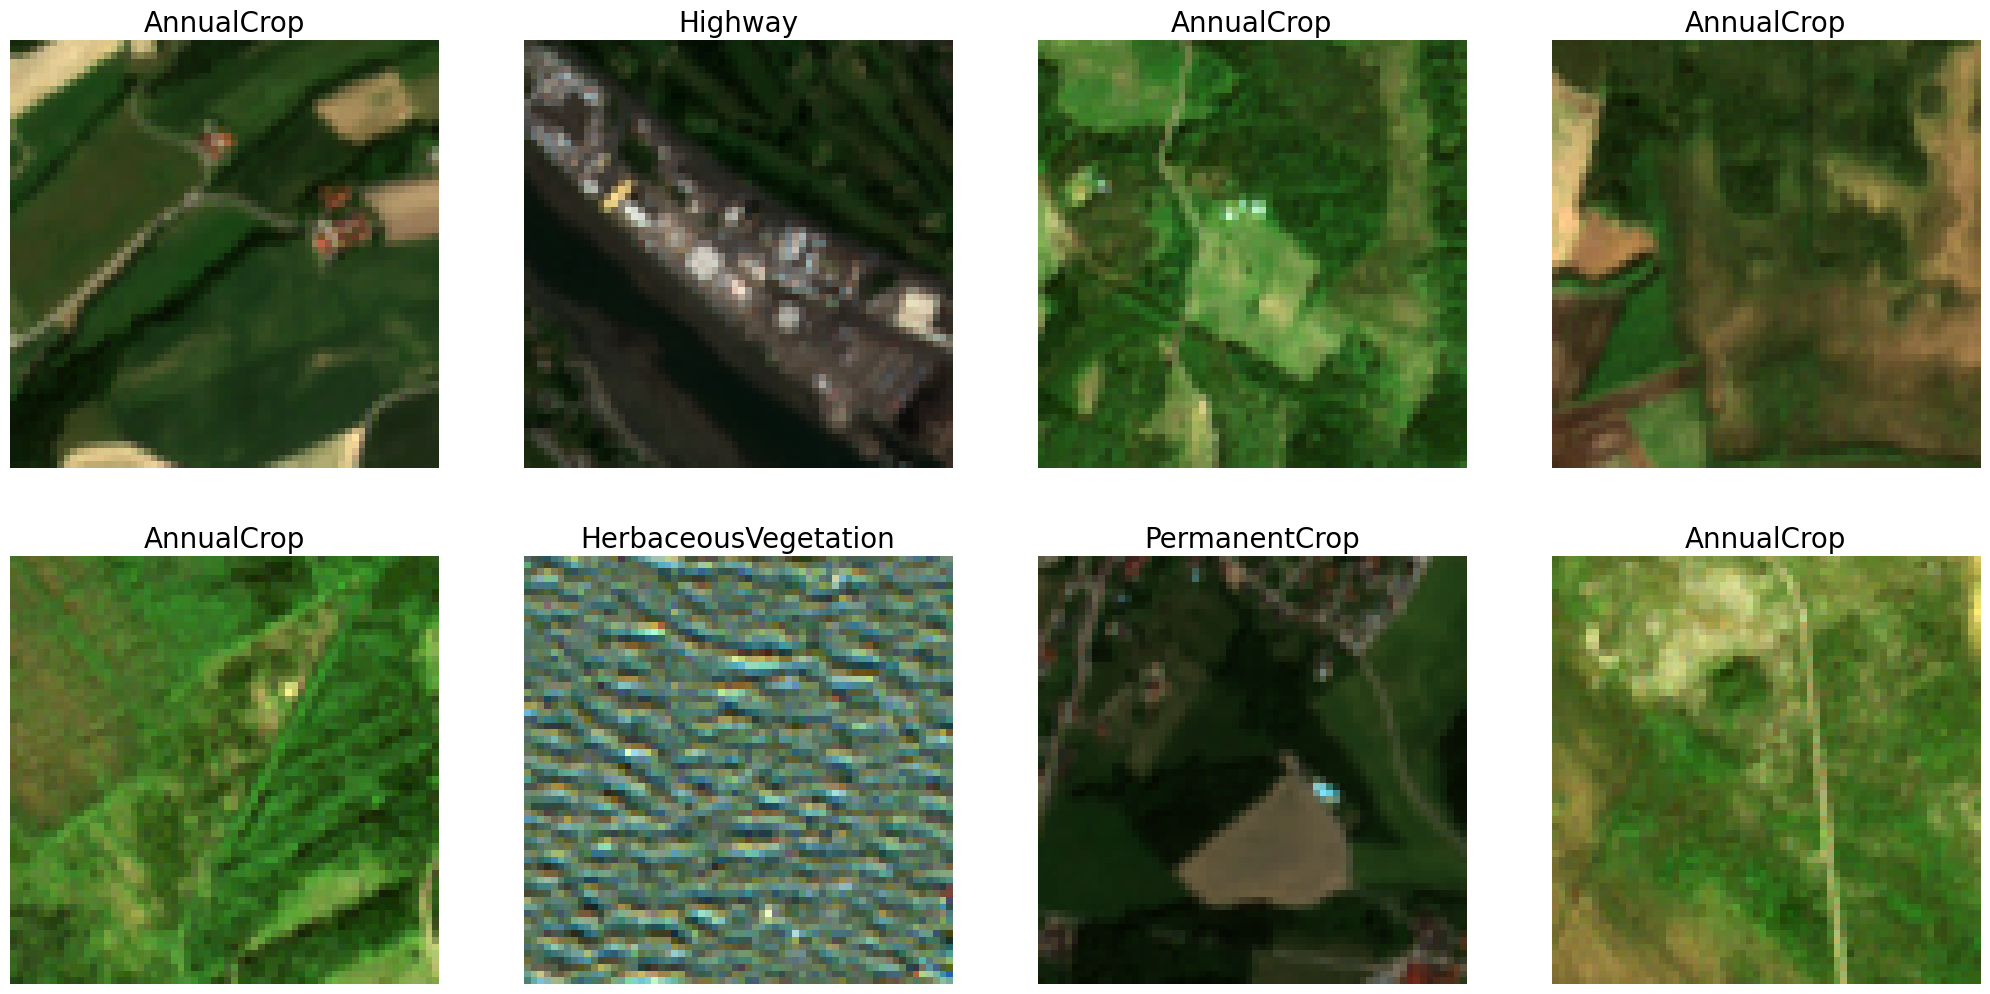

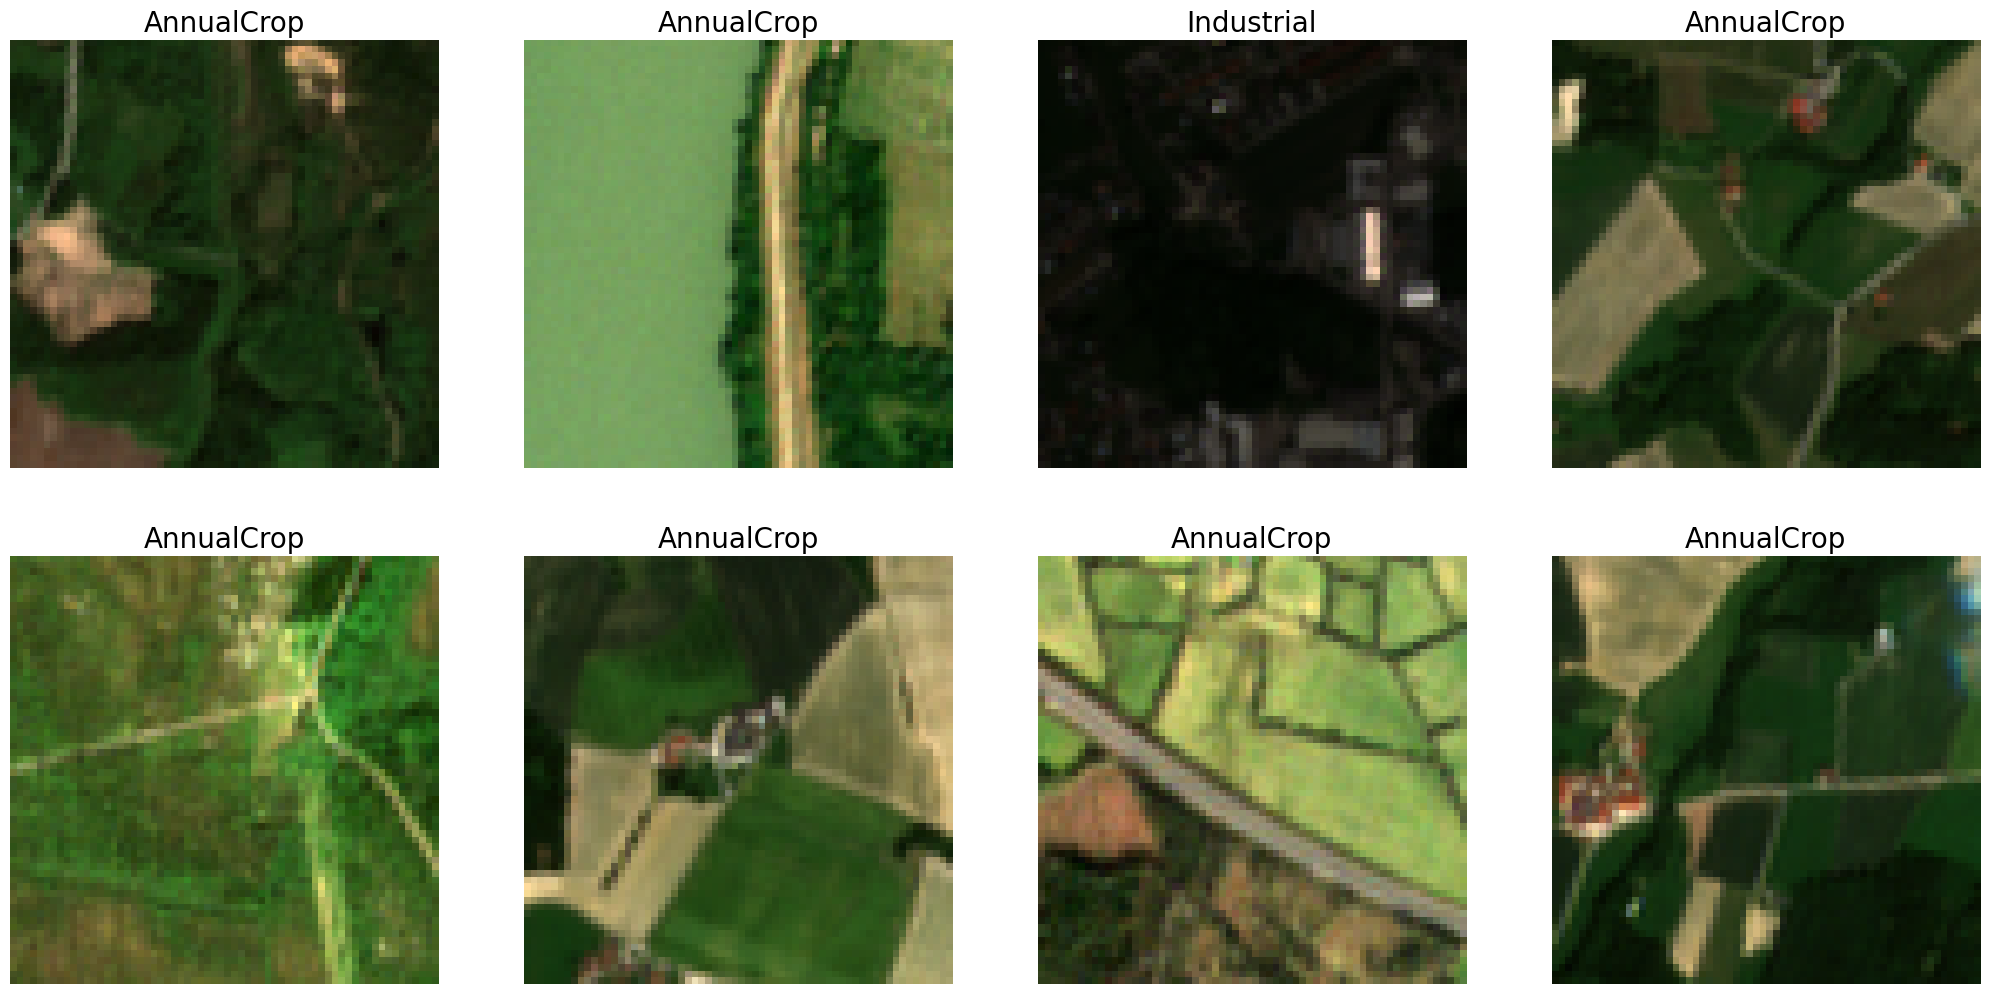

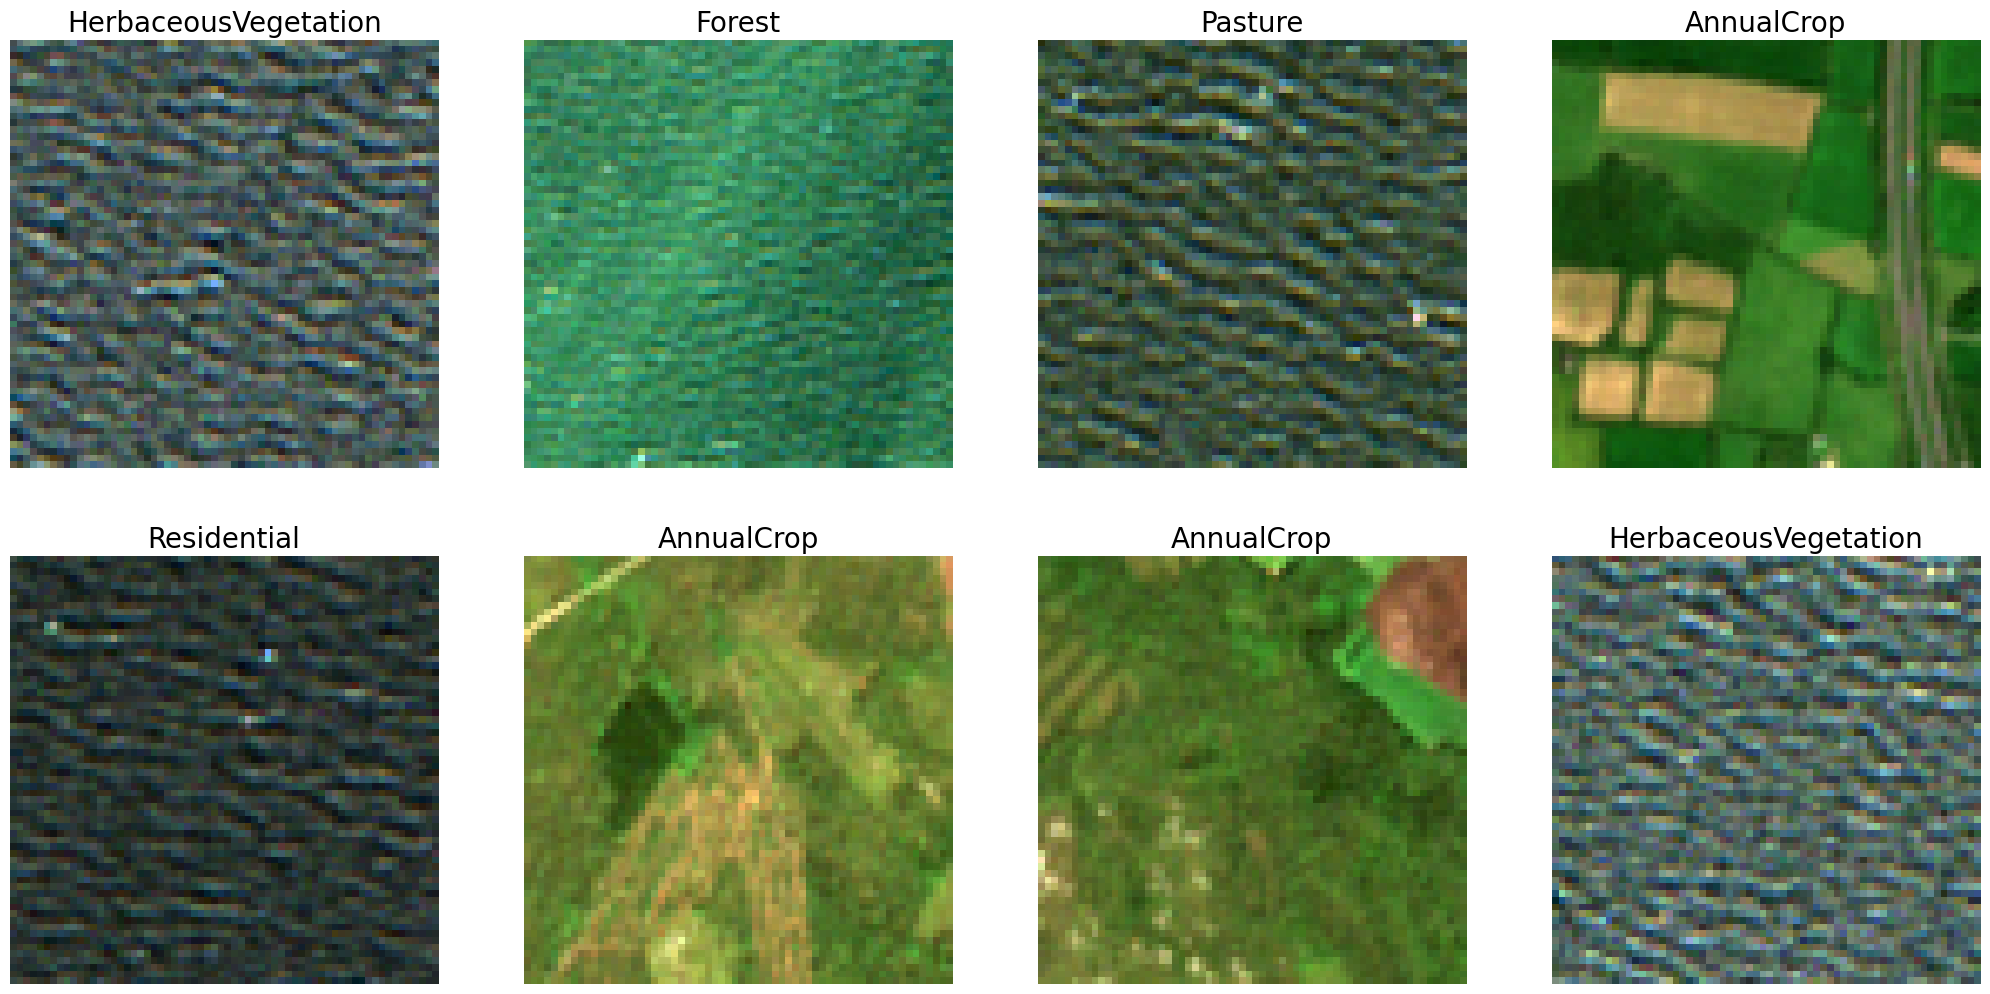

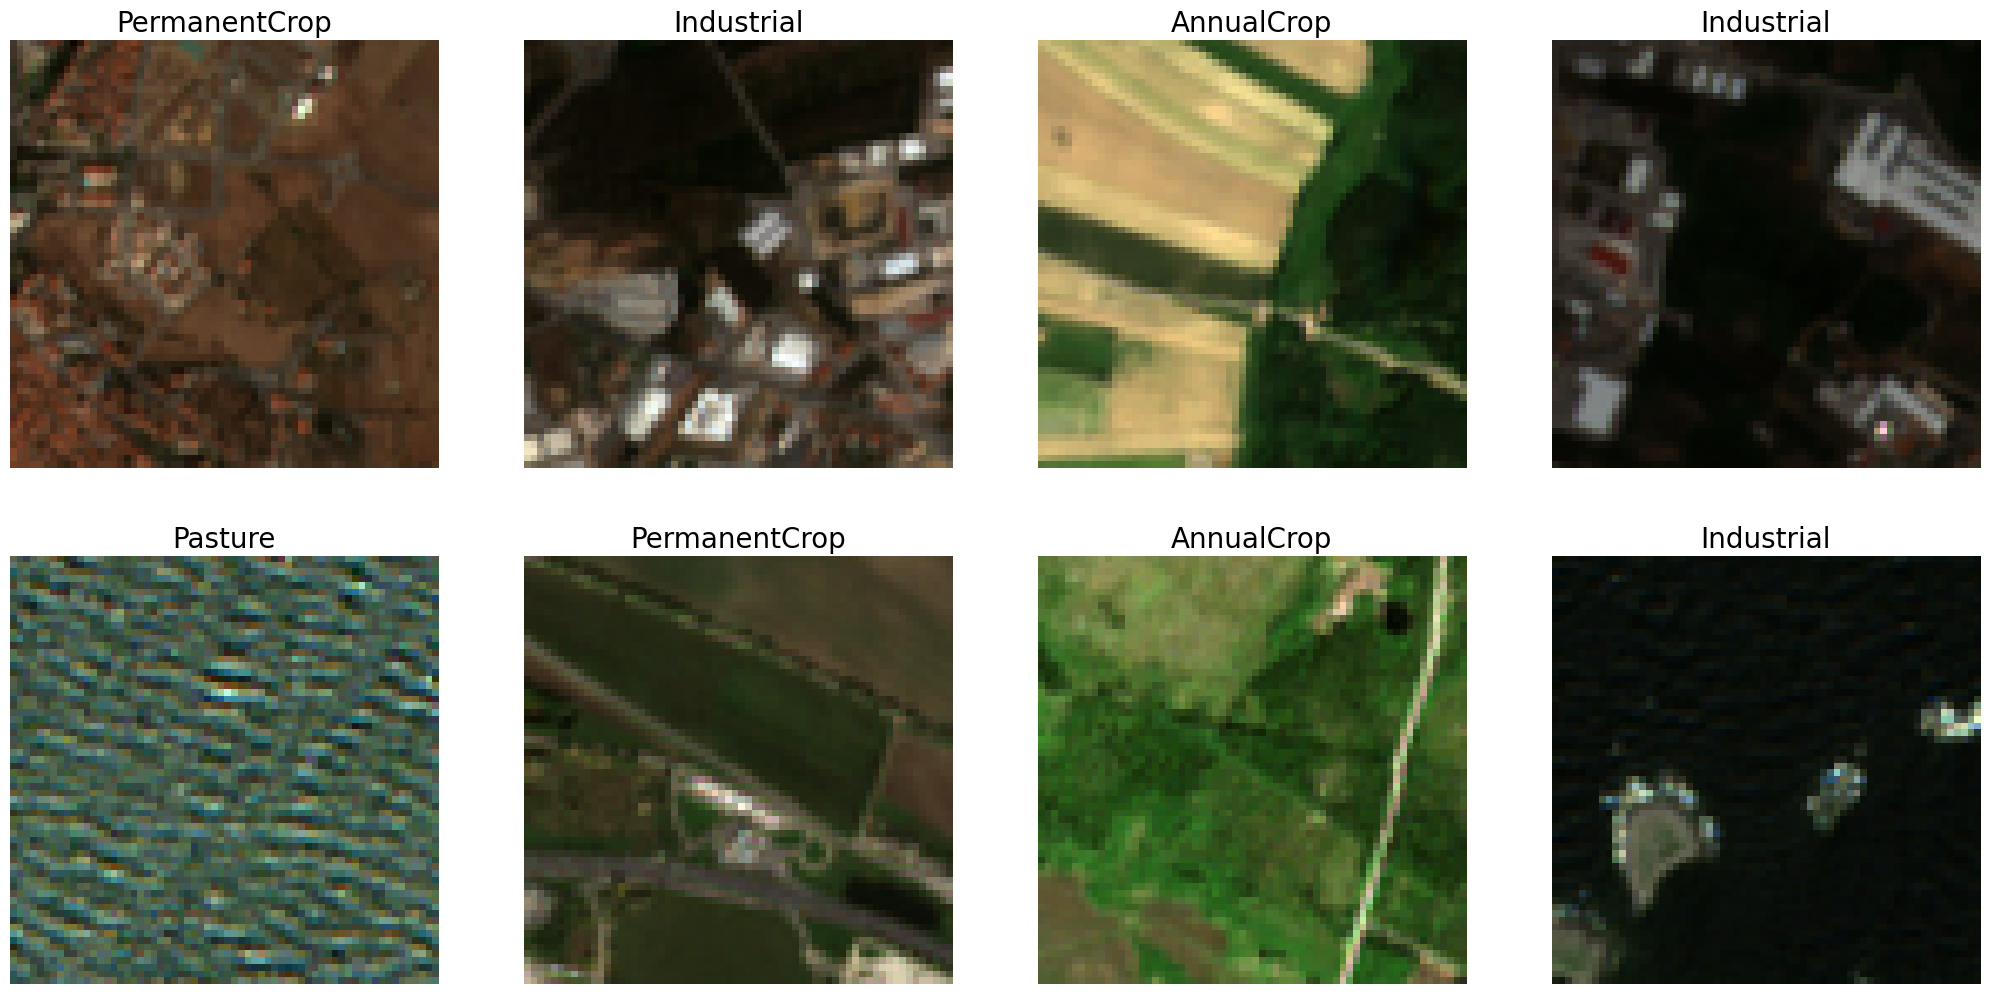

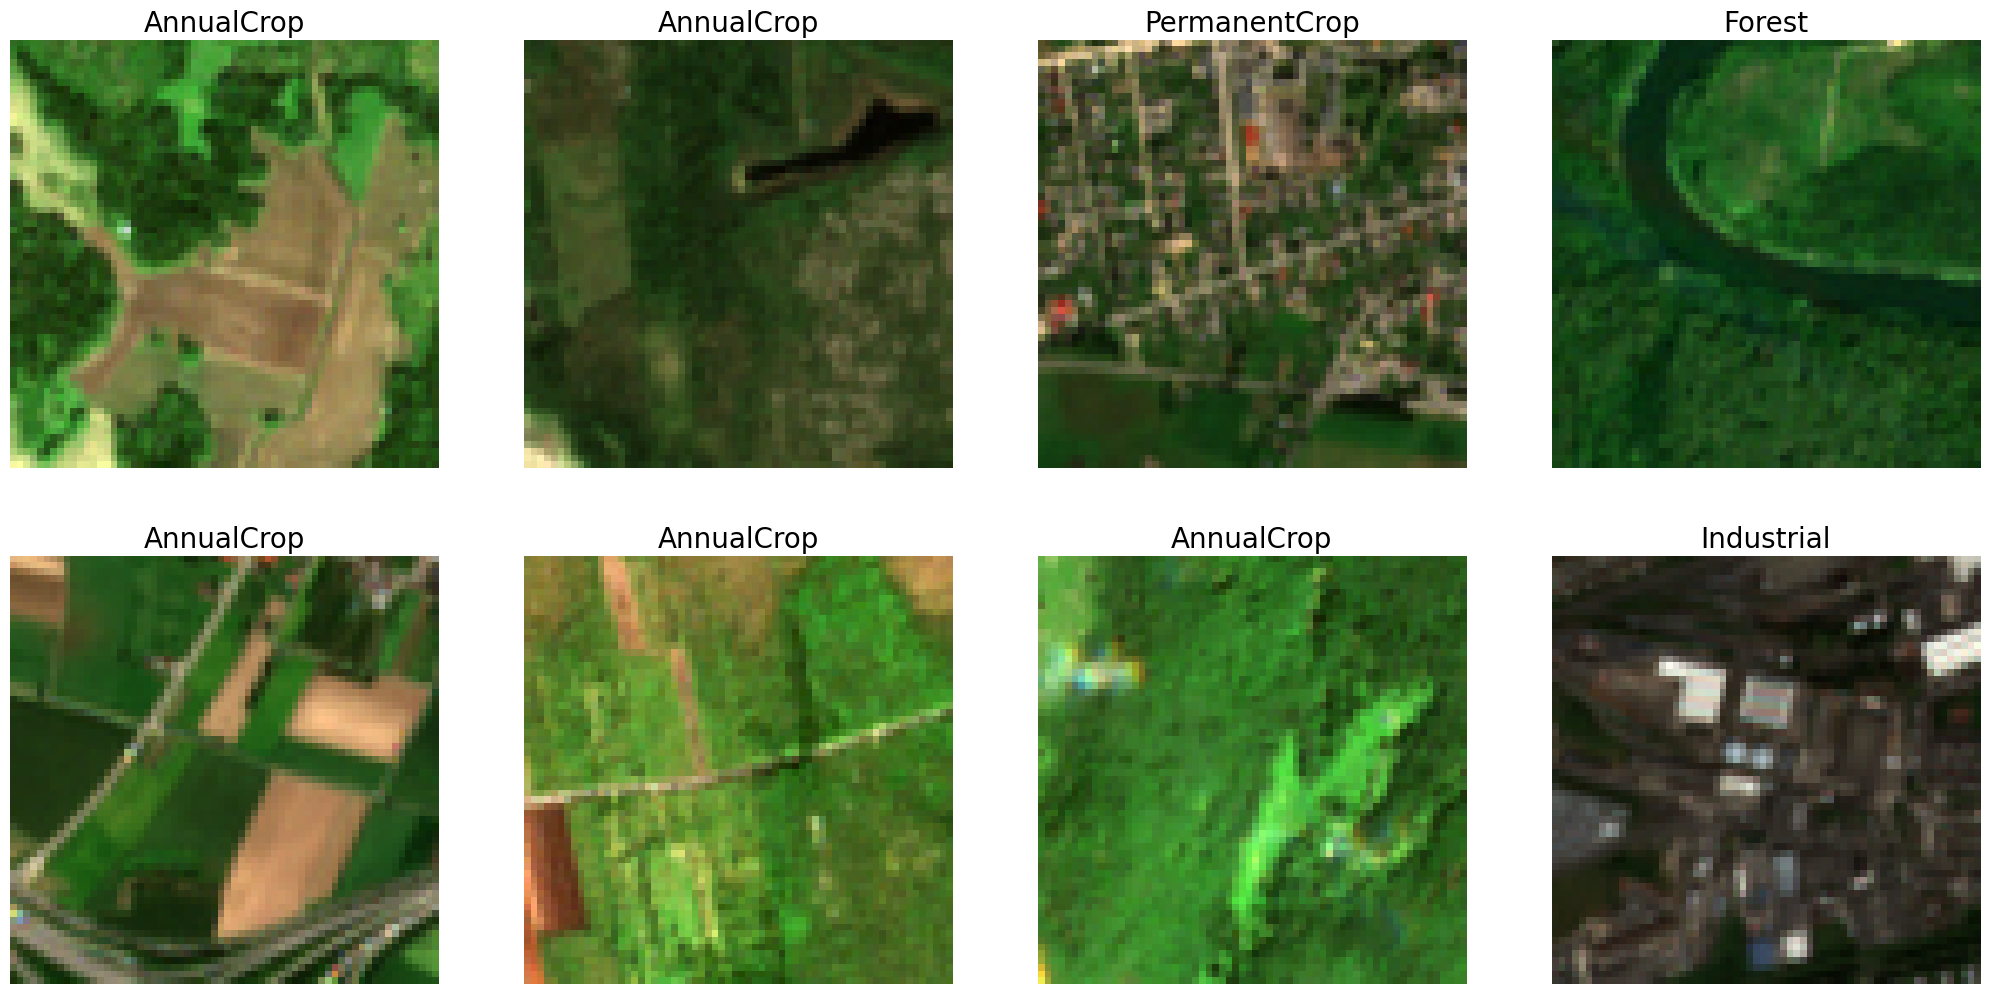

In [16]:
import random
from PIL import Image
from torchvision.transforms import v2 as T
from matplotlib import pyplot as plt

samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5

for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        
        raw = np.load(f"data/test/NoLabel/test_{samp_id}.npy")
        img = raw[:, :, [3, 2, 1]]

        # Normalize the image
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)

        # Plotting
        ax.imshow(img)
        ax.set_title(pred, fontsize=20)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()